#  RNN with GloVe Embeddings  
In this notebook, we will look at using trained word embeddings for our headlines data in a RNN model. Since good result for word embedding training can be achieved with big generic corpus, so it is usually more efficient to use existing embedding vectors from other resources as long as the semantics will match with your downstream tasks. After this notebook, you will be able to replace the embedding layer with the GloVe embeddings and tune your RNN model for a sementic analysis task.

**Outline**
- Load and process pretrained GloVe word2vec embeddings
- Build a classification RNN using GloVe embeddings
- Train and evaluate the RNN for semantic analysis  

**Estimated time:** 
 30 mins

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


In [3]:
print(torch.__version__)

1.10.2


In [2]:
# load our tokens back
with open('../data/tokens.pkl', 'rb') as f:
    tokens = pickle.load(f)
print(tokens[:10])

[['thirtysomething', 'scientist', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep', 'totally', 'nail', 'congress', 'falling', 'short', 'gender', 'racial', 'equality'], ['eat', 'veggie', 'deliciously', 'different', 'recipe'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'come', 'pretty', 'close', 'using', 'word', 'streaming', 'correctly'], ['white', 'inheritance'], ['way', 'file', 'tax', 'le', 'stress'], ['richard', 'bransons', 'globalwarming', 'donation', 'nearly', 'much', 'cost', 'failed', 'balloon', 'trip'], ['shadow', 'government', 'getting', 'large', 'meet', 'marriott', 'conference', 'room', 'b'], ['lot', 'parent', 'know', 'scenario']]


## GloVe Embedding


For this workshop, we use a pretrianed GloVe word vectors that is trained from wikipedia in 2014. GloVe models are trained by using word-word co-occurance statistics from the corpus. We are using the smallest word vectors with 6 billion uncased tokens and about 822MB in size.  

Say $x_{ij}$ is the frequency that word $j$ occurs in the context of word $i$, for example, before or after the word $i$ within 10 words. If using $k$ to represent any word, then the frequency for any word to occur in woed $i$ context, we have 

$$x_{i}=\sum_{k} x_{ik}$$  

and the probability of word $j$ to occur in the context of word $i$ (Co-occurance probability) is 
$$p_{ij}=P(w_j\mid w_i)=\frac{x_{ij}}{x_i}$$

Then a function was designed to be equal to $$\frac{p_{ik}}{p_{jk}}$$ so the process of training is to minimise the loss between the designed the function and the fraction of co-occurrance probability.  

[Learn more about GloVe](https://nlp.stanford.edu/projects/glove/)   

<div class="alert alert-block alert-info">

Word vectors is a representation of words co-occurance, so if you want to build a model for ancient literatures, sci-fi novels, hate speeches or other type of text that has very different word-word relationships, you can choose to train your own word vectors by building a word2vec modle in pytorch.
</div>


In [3]:
# download GoVe
# !curl https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip -o glove.6B.zip
# !unzip glove.6B.zip

Now lets have a look at the word vectors. You can choose different dimensions, 50, 100, 200 or 300 to compare their performance in later tasks. But keep in mind that this will impact the number of dimensions in the neural network as well.

In [3]:
glove = pd.read_csv('../data/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
the,-0.038194,-0.244870,0.72812,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,...,0.016215,-0.017099,-0.389840,0.87424,-0.72569,-0.51058,-0.520280,-0.14590,0.82780,0.270620
",",-0.107670,0.110530,0.59812,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,-0.094189,...,0.349510,-0.722600,0.375490,0.44410,-0.99059,0.61214,-0.351110,-0.83155,0.45293,0.082577
.,-0.339790,0.209410,0.46348,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,-0.019169,...,-0.063351,-0.674120,-0.068895,0.53604,-0.87773,0.31802,-0.392420,-0.23394,0.47298,-0.028803
of,-0.152900,-0.242790,0.89837,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,...,0.187120,-0.018488,-0.267570,0.72700,-0.59363,-0.34839,-0.560940,-0.59100,1.00390,0.206640
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,...,-0.131340,0.058617,-0.318690,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.159830


Now we put it in a dictionary so we can look up a word for its vector.
<div class="alert alert-block alert-warning">
<b>Task 1.</b> <br>
Put glove data in a dictionary, with words being the keys and row vectors being the array values.
</div>

In [4]:
### TODO
glove_embedding = {key: val.values for key, val in glove.T.items()}

<details><summary><b>Solution</b></summary>
    
    glove_embedding = {key: val.values for key, val in glove.T.items()}

</details>

In [5]:
glove_embedding['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Now we need to extract the vectors from glove to match with our dataset vocabulary. We achieve this by building a weight matrix with the shape of `len(vocabulary) x word_vector_dimension`. This matrix of weights will then be loaded into our embedding layer of the model.

In [12]:
vocab = list(set([w for t in tokens for w in t]))
vocab_size = len(vocab)
print('Vocabulary size:{}'.format(vocab_size))

Vocabulary size:25101


<div class="alert alert-block alert-warning">
<b>Task 2. Complete the function: getGloveWeight( )</b><br>
- Input parameter: the vocabulary, glove_embedding dictionary <br><br>
- Output parameter: a weights_matrix of shape vocabulary_length x embedding dimmension <br><br>
If the word in vocabulary exists in glove_embedding, assign the embedding values to the corresbonding row of weights_matrix; otherwise assign a random normal distribution numpy array.

</div>

In [6]:
def getGloveWeight(vocab, glove_embedding):
    
    ### TODO 2.1: initialise the empty matrix with the correct shape
    weights_matrix =  np.zeros((len(vocab), len(glove.columns)))
    
    for i, w in enumerate(vocab):
        # if word exists in glove embedding, we add the embedding vector to weight matrix
        if w in glove_embedding.keys():
            
            ### TODO 2.2: add the embedding vector to correct place in weight matrix
            weights_matrix[i] = glove_embedding[w]
        # otherwise we intialise a random variable. 
        else: 
            weights_matrix[i] = np.random.normal(scale=0.6, size=(weights_matrix.shape[1], ))
    return weights_matrix

<details><summary><b>Solution</b></summary>
  
    ### TODO 2.1   
    weights_matrix = np.zeros((len(vocab), len(glove.columns))) 
    ### TODO 2.2   
    weights_matrix[i] = glove_embedding[w]


</details>

The embedding layer stores the vectors of all vocabulary in a weight matrix, and accepts indexes for words to extract corresponding rows of vetors for each sequence input. The above function created the weight matrix. So we need to create the word_to_idx and idx_to_word dictionaries.  
To feed the embeddings to the model later, we also need to make all sequenecs of tokens the same length. For padding shorter sequences, we add the special token `<pad>` to our vocabulary.


In [13]:
glove_embedding['<pad>'] = np.zeros((1,100))
vocab.append('<pad>')

idx_to_word = {}
for i, w in enumerate(vocab):
    idx_to_word[i] = w

word_to_idx = {}
for i, w in enumerate(vocab):
    word_to_idx[w] = i

print(word_to_idx['thirtysomething'])

1075


Now we need to tranform our sequence of tokens to word indexes, also make them all the same length. Here we define sequence length as 15 and pad the short sequences with our special token while truncing the longer sequences.  
  
<div class="alert alert-block alert-warning">
<b>Task 3. Complete the function: formatLength( )</b><br>
- Input parameter: the list of list of tokens, expected length <br><br>
- Output parameter: the result list of list of tokens that all token lists have the expected length <br><br>


</div>


In [14]:
seq_length = 15
def formatLength(l, seq_length):
    newl=[]
    for i, s in enumerate(l):
        
        ### TODO 3: padding sequences that have length shorter than seq_length
        if len(s)<=seq_length:
            new_s =  s + ["<pad>"]*(seq_length-len(s))
            
        # truncting longer sequences
        else:
            new_s=s[:seq_length]  
        newl.append(new_s)
    return newl

<details><summary><b>Solution</b></summary>
    
    ### TODO 3   
    new_s = s + ["&lt;pad&gt;"]*(seq_length-len(s)) 
  

</details>

Now we transfer our equal-length token lists from words to index using the word_to_index dictionary. Also confirm that all lists have the same length as specified in seq_length.

In [15]:
idx_tokens = torch.tensor([[word_to_idx[w] for w in t] for t in formatLength(tokens,seq_length)])
[print(len(l)) for l in idx_tokens if len(l)!=seq_length]

[]

Now let's string above functions together and create the embedding layer with our new weights.
<div class="alert alert-block alert-warning">
<b>Task 4. Complete the function: createEmbeddings( )</b><br>
- Input parameter: the list of vocabulary, glove embedding dictionary <br><br>
- Output parameter: torch embedding layer with GloVe weights. <br><br>

</div>



In [16]:
# transfer our tokens to vectors
def createEmbeddings(vocab, glove_embedding):
    ### TODO 4.1: create weight matrix from GloVe weights by calling getGloveWeight()
    weights_matrix = getGloveWeight(vocab, glove_embedding)
    
    # load the weight matrix to a nn.Embedding layer, freeze=True means embedding weights will not be trained 
    ### TODO 4.2: convert weight_matrix to float tensor
    emb_weights =  torch.FloatTensor(weights_matrix)
    
    ### TODO 4.3: create embedding layer from pretrained weights
    emb_layer = nn.Embedding.from_pretrained(emb_weights,freeze=True)
    return emb_layer

**Building blocks:**   
- [torch.Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) 
- [`torch.nn.Embedding` class method `from_pretrained(embeddings, freeze=True, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False`](https://pytorch.org/docs/stable/_modules/torch/nn/modules/sparse.html#Embedding.from_pretrained)

<details><summary><b>Solution</b></summary>
    
       ###TODO 4.1:  
       weights_matrix = getGloveWeight(vocab, glove_embedding)   
       ###TODO 4.2:  
       emb_weights = torch.FloatTensor(weights_matrix)   
       ###TODO 4.3:  
       emb_layer = nn.Embedding.from_pretrained(emb_weights,freeze=True)
</details>

<div class="alert alert-block alert-info"> 
Until now, we introduced static word embeddings, which means the same words will have the same weights in all texts they occur. There is also later developed dynamic word embeddings, which means for each occurence of the same word, the weight vectors depends on the context words around each occurence. You can find out more about <a href="https://dl.acm.org/doi/fullHtml/10.1145/3178876.3185999">dynamic word embeddings</a>.
</div>

# Build RNN

## Prepare Data for Training

In [20]:
# load our cleaned data back
with open('../data/data_clean.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientist unveil doomsday cloc...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nail congress falling short ge...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat veggie deliciously different recipe,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...
4,1,mother come pretty close using word streaming ...,https://www.theonion.com/mother-comes-pretty-c...


Since we have transferred our data to vectors, we can call `TensorDataset` to load them.

In [21]:
labels = torch.FloatTensor(data.is_sarcastic.to_list())
# split train test by 80/20
training_data = TensorDataset(idx_tokens[:22895], labels[:22895])
test_data = TensorDataset(idx_tokens[22895:], labels[22895:])
# DataLoader to iterate and batch data quickly
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [22]:
training_data[0]

(tensor([ 1075,  9556, 11672, 13203,  9113,  2410,   911, 25101, 25101, 25101,
         25101, 25101, 25101, 25101, 25101]),
 tensor(1.))

<div class="alert alert-block alert-info"> 
Play with different batch_size and learning rate later to see the model performance.

</div>

## Define simpleRNN  
Here we use the default embeddings first and Train the RNN. You can switch to the Glove Embeddings later and run below cells again to see the performance difference.

In [40]:
class simpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, out_size):
        super(simpleRNN,self).__init__()        
        # use Golve Embeddings, no training on embedding
#         self.embeddings  = createEmbeddings(vocab,glove_embedding) 

        # use original embedding with training
        self.embeddings  = nn.Embedding(vocab_size,embedding_dim)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(embedding_dim, 
                          hidden_size, 
                          num_layers, 
                          batch_first = True,
                          dropout = 0,
                          bidirectional = False
                     )
        self.out = nn.Linear(hidden_size, out_size)
        
    def forward(self, batch):
        batch_size = batch.size()[0]
        embed = self.embeddings(batch)
        rnn_out, hidden = self.rnn(embed)
        result = self.out(rnn_out[:,-1,:])
        return result
    
    

# Training

In [41]:
embed_dim = len(glove.columns)
hidden_size, num_layers = 50, 1
output_size = 1
vocab_size = len(vocab)

model = simpleRNN(vocab_size, embed_dim, hidden_size, num_layers,output_size)

print(model)

simpleRNN(
  (embeddings): Embedding(25102, 100)
  (rnn): RNN(100, 50, batch_first=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
)


Number of threads:  20
Epoch 0, loss: 0.2582254707813263, accuracy: 0.5090194365582005
Epoch 1, loss: 0.2506135106086731, accuracy: 0.5112033195020746
Epoch 2, loss: 0.24763482809066772, accuracy: 0.5235204193055252
Epoch 3, loss: 0.24678392708301544, accuracy: 0.5247433937540947
Epoch 4, loss: 0.25072333216667175, accuracy: 0.53107665429133


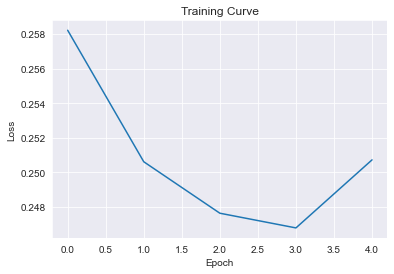

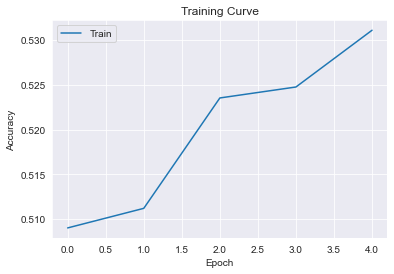

CPU times: user 40.9 s, sys: 1min 49s, total: 2min 30s
Wall time: 29.4 s


In [42]:
%%time
print("Number of threads: ", torch.get_num_threads())

# Training
num_epochs, lr = 5, 0.01
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

losses, train_acc= [], []
epochs = []

model.train()
for e in range(num_epochs):
    num_correct = 0
    for d, l in train_dataloader:
        model.zero_grad()
        scores = model(d)
        pred = torch.round(scores.squeeze())
        
        correct_tensor = pred.eq(l.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy())
        num_correct += np.sum(correct)
        loss = loss_function(scores.squeeze(), l)
        loss.backward()
        optimizer.step()
    epochs.append(e)
    losses.append(float(loss))
    acc = num_correct/len(train_dataloader.dataset)
    train_acc.append(acc)
    print('Epoch {}, loss: {}, accuracy: {}'.format(e, loss, acc))

# plot the results
plt.title("Training Curve")
plt.plot(losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(epochs, train_acc, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

# Testing

In [43]:
# Testing
test_losses = []
num_correct = 0

model.eval()
# iterate over test data
for inputs, labels in test_dataloader:
    # calculate loss
    scores = model(inputs)
    loss = loss_function(scores.squeeze(), labels)    
    test_losses.append(loss.item())
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(scores.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)
# avg test loss
print("Test loss: {}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {}".format(test_acc))

Test loss: 0.24690110815895927
Test accuracy: 0.5688329839273235


> Think:  
> What should we do if the model is overfitting?   
>



<div class="alert alert-block alert-warning">
<b>Task 5. Tuning for better performance</b><br>
    1. Change hyperparameters<br>
    2. Change batch_size<br>
    3. Change optimizor<br>
    4. Change nn.RNN parameters
    
    
</div>

**Building blocks:**   
- [`torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False, foreach=None)`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)  
- [Other optimizors](https://pytorch.org/docs/stable/optim.html#algorithms)  
- [nn.RNN parameters](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)

<div class="alert alert-block alert-danger">
<b>Challenge/Homework:</b> <br>
    1. Change num_layers to see the result.<br>
    2. Add a drop out layer in the model class to improve the result. <br>
    3. Change model to bidirectional, be careful with the shape match! <br>
    4. Upgrade the model to LSTM or adding Attention layer if you have extra time.
</div>  

------------------------------------------  

Congratulations! After Notebook 1 and 2, you now can clean text data, make tokens, and load the pre-trained weights to an embedding layer in your RNN. In the [next notebook](3-Q&A_bert.ipynb), we will make a small widget to answer questions from a text corpus using fine-tuned transformers. 